fy_year
2009    1128
2010    2700
2016    1058
2017    5013
Name: provider_number, dtype: int64


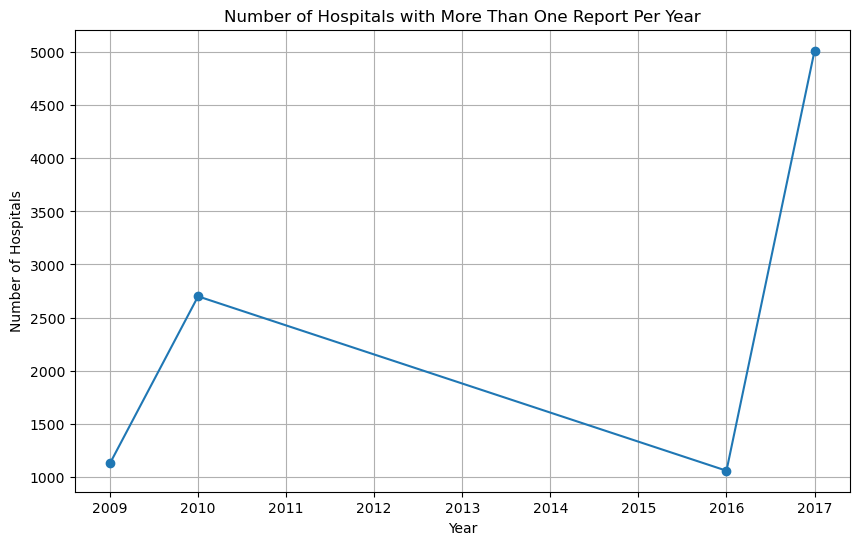

In [1]:
#1 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#reading data
hcris = pd.read_csv('../../data/Output/HCRIS.csv')

#Converting to datetime format
hcris['fy_start'] = pd.to_datetime(hcris['fy_start'])
hcris['fy_end'] = pd.to_datetime(hcris['fy_end'])

#Extract the year 
hcris['fy_year'] = hcris['fy_start'].dt.year

# Filter data to get hospitals with more than one report in the same year
duplicate_hospitals = hcris.groupby(['provider_number', 'fy_year']).size().reset_index(name='report_count')
multiple_reports = duplicate_hospitals[duplicate_hospitals['report_count'] > 1]

# Count unique hospitals that filed more than one report per year
hospitals_multiple_reports = duplicate_hospitals.groupby('fy_year')['provider_number'].nunique()


# Display the number of hospitals filing more than one report each year
print(hospitals_multiple_reports)





# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_multiple_reports.index, hospitals_multiple_reports.values, marker='o')
plt.title("Number of Hospitals with More Than One Report Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Hospitals")
plt.grid(True)
plt.show()



In [2]:
#Question 2

#Removing duplicate reports
unique_hospitals = hcris.drop_duplicates(subset=['provider_number', 'fy_year'])

#Count of number of unique hospital IDs
unique_hospital_count = unique_hospitals['provider_number'].nunique()

print(f"Number of Unique Hospital IDs: {unique_hospital_count}")



Number of Unique Hospital IDs: 6383


count    9.626000e+03
mean     5.151527e+08
std      1.041055e+09
min      2.382510e+05
25%      3.736317e+07
50%      1.231088e+08
75%      5.544906e+08
max      1.863371e+10
Name: tot_charges, dtype: float64


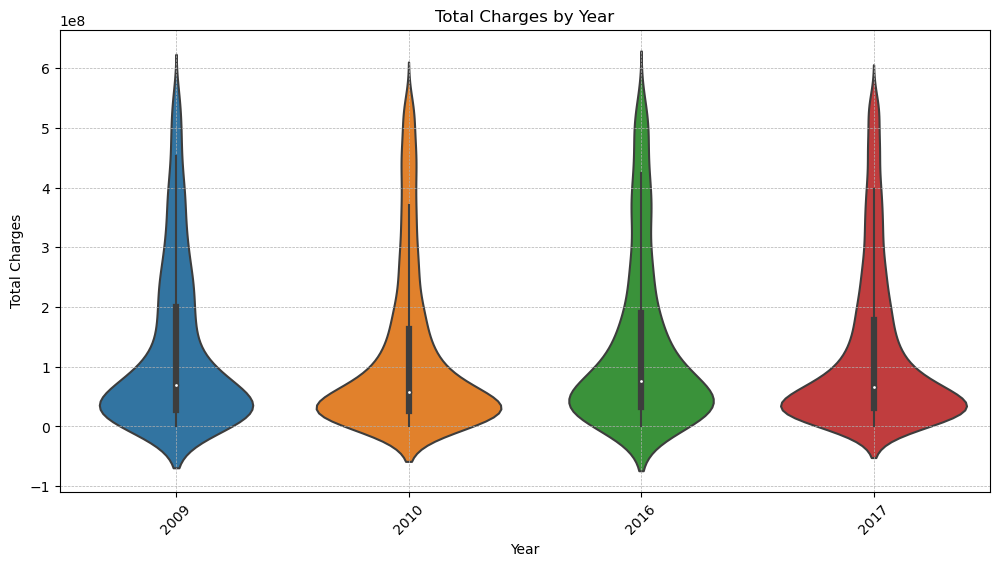

In [14]:
#Question 3 
hcris['tot_charges'] = pd.to_numeric(hcris['tot_charges'], errors='coerce')

# Convert tot_charges to numeric
hcris['tot_charges'] = pd.to_numeric(hcris['tot_charges'], errors='coerce')

#Remove rows with missing charges or years, negative values, and outliers
charges_by_year = hcris[['fy_year', 'tot_charges']].dropna()
charges_by_year = charges_by_year[charges_by_year['tot_charges'] >= 0]

# Display summary statistics to find  cutoff values
summary_stats = charges_by_year['tot_charges'].describe() 
print(summary_stats)

#creating upper bound limit
upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
charges_by_year = charges_by_year[charges_by_year['tot_charges'] <= upper_bound]

# Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='fy_year', y='tot_charges', data=charges_by_year)
plt.title("Total Charges by Year")
plt.xlabel("Year")
plt.ylabel("Total Charges")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


count      4485.000000
mean      10157.286465
std        6292.072321
min          81.780114
25%        6283.197885
50%        9032.902343
75%       12515.322081
max      104492.305807
Name: estimated_price, dtype: float64


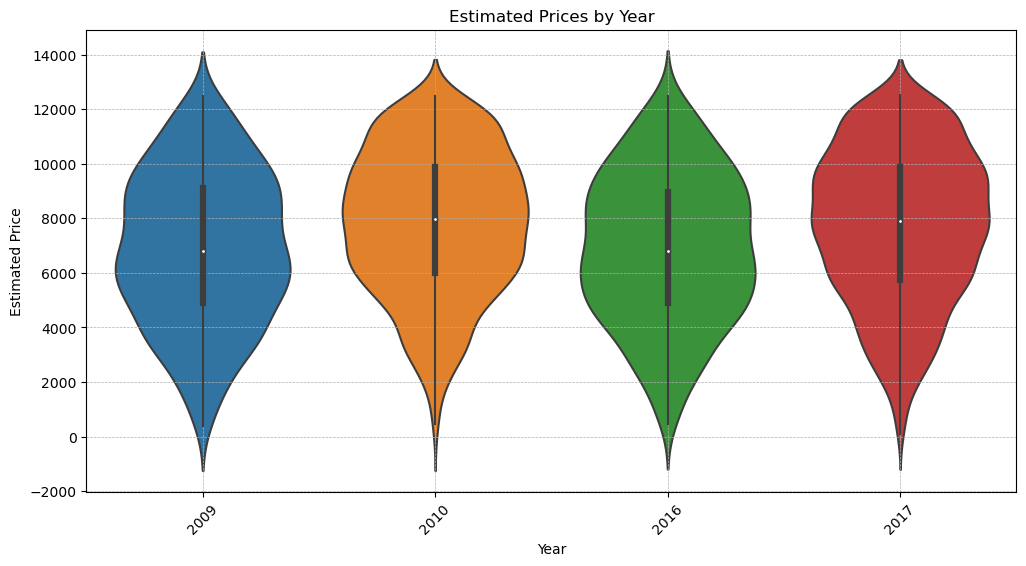

In [36]:
#Question 4

#Converting columns to numeric 
numeric_columns = [
    'tot_discounts', 'tot_charges', 'ip_charges', 'icu_charges', 'ancillary_charges',
    'tot_mcare_payment', 'tot_discharges', 'mcare_discharges'
]
hcris[numeric_columns] = hcris[numeric_columns].apply(pd.to_numeric, errors='coerce')


# Remove missing values
hcris_clean = hcris[['fy_year'] + numeric_columns].dropna()

# Calculate estimated price based on the formula
discount_factor = 1 - hcris_clean['tot_discounts'] / hcris_clean['tot_charges']
price_num = (hcris_clean['ip_charges'] + hcris_clean['icu_charges'] + hcris_clean['ancillary_charges']) * discount_factor - hcris_clean['tot_mcare_payment']
price_denom = hcris_clean['tot_discharges'] - hcris_clean['mcare_discharges']
hcris_clean['estimated_price'] = price_num / price_denom

#removing outliers and negatives
hcris_clean = hcris_clean[hcris_clean['estimated_price'] > 0]
summary_stats = hcris_clean['estimated_price'].describe()
print(summary_stats)

upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
hcris_clean = hcris_clean[hcris_clean['estimated_price'] <= upper_bound]

#Plot violin plot 
plt.figure(figsize=(12, 6))
sns.violinplot(x='fy_year', y='estimated_price', data=hcris_clean)
plt.title("Estimated Prices by Year")
plt.xlabel("Year")
plt.ylabel("Estimated Price")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()




In [28]:
#Question 5
hcris_2012 = hcris_df[hcris_df['fyear'] == 2012]

#Calculating estimated price for 2012
hcris_2012['discount_factor'] = 1 - hcris_2012['tot_discounts'] / hcris_2012['tot_charges']
hcris_2012['price_num'] = (
    (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges'])
    * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
)
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# NA payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

#Defining penalty 
hcris_2012['penalty'] = (hcris_2012['hvbp_payment'] - hcris_2012['hrrp_payment'] < 0).astype(int)

# Calculate average price for penalized vs non-penalized hospitals
mean_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean(), 2)
mean_non_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean(), 2)

print(f"Average price for penalized hospitals: {mean_penalized}")
print(f"Average price for non-penalized hospitals: {mean_non_penalized}")




Average price for penalized hospitals: nan
Average price for non-penalized hospitals: nan


In [31]:
#Question 6
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()





IndexError: index -1 is out of bounds for axis 0 with size 0

In [33]:
#Question 7 - Nearest Neighbor match
from sklearn.neighbors import NearestNeighbors

#Nearest neighbor match
results = []
for q in [1, 2, 3, 4]:
    subset = hcris_2012[hcris_2012['beds_quartile'] == q]
    treated = subset[subset['penalty'] == 1]
    control = subset[subset['penalty'] == 0]
    
    if treated.empty or control.empty:
        results.append({'Quartile': q, 'ATE': np.nan})
        continue


KeyError: 'beds_quartile'

In [34]:
# Question 7 - Mahalanobis distance Nearest Neighbor Match 

results = []
for q in [1, 2, 3, 4]:
    subset = hcris_2012[hcris_2012['beds_quartile'] == q]
    treated = subset[subset['penalty'] == 1]
    control = subset[subset['penalty'] == 0]

    if treated.empty or control.empty:
        results.append({'Quartile': q, 'ATE': np.nan})
        continue

    covariates = ['beds', 'mcare_discharges', 'ip_charges', 'tot_mcare_payment']
    treated_cov = treated[covariates].values
    control_cov = control[covariates].values

    # Calculate the covariance matrix for Mahalanobis distance
    cov_matrix = np.cov(np.vstack([treated_cov, control_cov]).T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    treated_prices = []
    control_prices = []

    for i, treated_row in enumerate(treated_cov):
        distances = [distance.mahalanobis(treated_row, control_row, inv_cov_matrix) for control_row in control_cov]
        nearest_idx = np.argmin(distances)

        treated_prices.append(treated.iloc[i]['price'])
        control_prices.append(control.iloc[nearest_idx]['price'])

    ate = np.mean(np.array(treated_prices) - np.array(control_prices))
    results.append({'Quartile': q, 'ATE': round(ate, 2)})

KeyError: 'beds_quartile'

In [35]:
# Question 7 - Inverse Propensity Weighting 
results = []
for q in [1, 2, 3, 4]:
    subset = hcris_2012[hcris_2012['beds_quartile'] == q]
    
    # Estimate propensity score
    covariates = ['beds', 'mcare_discharges', 'ip_charges', 'tot_mcare_payment']
    X = sm.add_constant(subset[covariates])
    y = subset['penalty']
    logit_model = sm.Logit(y, X).fit(disp=0)
    subset['propensity_score'] = logit_model.predict(X)


KeyError: 'beds_quartile'

In [ ]:
#